In [ ]:
import kagglehub
natural_images_path = kagglehub.dataset_download("rakeshdasdata/rakesh-obj-detection-dataset")
the_car_connection_picture_dataset_path = kagglehub.dataset_download("rakeshdasdata/rakesh-obj-detection-dataset-2")

test_images = kagglehub.dataset_download("rakeshdasdata/rakesh-obj-detection-testing")


# Inspired by the work from the below sources on Kaggle:
# https://www.kaggle.com/code/abdalrahmanshahrour/image-classification-with-cnn-model
# https://www.kaggle.com/code/ghieu0123/car-detection-using-svm
# Assistance provided by ChatGPT (OpenAI) for idea generation and explanations.


100%|██████████| 342M/342M [00:06<00:00, 56.7MB/s]

Extracting files...


100%|██████████| 682M/682M [00:10<00:00, 70.0MB/s]

Extracting files...


In [ ]:
import shutil
shutil.move(natural_images_path, '/content/natural-images') # Move to /content
shutil.move(the_car_connection_picture_dataset_path, '/content/the-car-connection-picture-dataset') # Move to /content
shutil.move(test_images, '/content/test_images') # Move to /content


'/content/the-car-connection-picture-dataset'

# Introduction

This notebook demonstrates the implementation of a  object detector using a Support Vector Machine (SVM) classifier and the sliding window localization technique. The project aims to identify and locate cars within images by leveraging the discriminative power of SVMs and a comprehensive search strategy.

**Background:**

Object detection is a crucial task in computer vision, enabling machines to perceive and understand the visual world by identifying and localizing specific objects within images or videos. Traditional object detection methods, such as the one explored in this notebook, often rely on handcrafted features and classifiers like SVMs. While deep learning-based approaches have gained significant traction recently, understanding fundamental techniques like sliding window and SVM-based detection remains valuable.

**Approach:**

This notebook follows a step-by-step approach to build the car object detector:

1. **Data Preparation:** We start by importing necessary libraries and preparing the dataset, which includes images of cars and non-car objects.
2. **Feature Extraction:** We utilize the Histogram of Oriented Gradients (HOG) descriptor to extract relevant features from the images, enabling the SVM to distinguish between cars and other objects.
3. **Classifier Training:** An SVM classifier is trained on the extracted features to learn the patterns that characterize cars.
4. **Sliding Window Localization:** We employ a sliding window approach to scan the image for potential car locations. For each window, the HOG features are extracted and fed to the SVM for classification.
5. **Heatmap Generation:** A heatmap is generated to visualize the regions of the image where the classifier predicts the presence of cars.
6. **Object Detection:** Based on the heatmap, bounding boxes are drawn around the detected car objects, highlighting their locations within the image.

**Objectives:**

- To illustrate the concept of sliding window localization for object detection.
- To demonstrate the application of SVM classifiers in image classification tasks.
- To provide a foundational understanding of traditional object detection techniques.

**Dataset:**

The project utilizes two publicly available datasets:
1. **Natural Images Dataset** which contains various natural images for negative samples.
2. **The Car Connection Picture Dataset** for positive car samples.

**Results and Conclusion:**

By the end of this notebook, we will have built a functional car object detector, albeit with limitations in terms of speed and efficiency. While not as sophisticated as modern deep learning-based detectors, this implementation provides a clear understanding of the underlying principles of object detection.


**Further Improvements**

The presented method is a basic implementation for understanding the concepts. Further improvements could involve using deep learning models for better accuracy and faster inference.

**Integration with a Blind Stick**

The car object detection system developed in this notebook can be adapted to aid blind individuals in navigating their surroundings. By incorporating the system into a blind stick, we can provide real-time object detection capabilities that enhance safety and awareness.

# Setting up the Environment and Data
This section focuses on importing the necessary libraries and preparing the data for building our car object classifier.

In [ ]:

import os
import PIL
import cv2
import time
import pickle
import random
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

### Determining paths of images:

In [ ]:
car_paths = glob("/content/the-car-connection-picture-dataset"+"/*")[:5000]
neg_paths = []

for class_path in glob("/content/natural-images/natural_images"+"/*"):
    if class_path != "/content/natural-images/natural_images/car":
        paths = random.choices(glob(class_path+"/*"),k=700)
        neg_paths = paths + neg_paths

print("There are {} car images in the dataset".format(len(car_paths)))
print("There are {} negative images in the dataset".format(len(neg_paths)))


There are 5000 car images in the dataset
There are 4900 negative images in the dataset


### Reading Images and Feature Extraction
Instead of using raw image data directly, which can be computationally expensive and contain redundant information, we employ feature extraction techniques in image classification.

Deep learning methods typically use convolutional kernels (learnt filters) to extract relevant features. However, for this project, we are focusing on a machine learning-based approach and will utilize the Histogram of Oriented Gradients (HOG) descriptor, a statistical method that captures the distribution of gradient orientations within an image.

Below, we demonstrate how an image looks after HOG feature extraction.

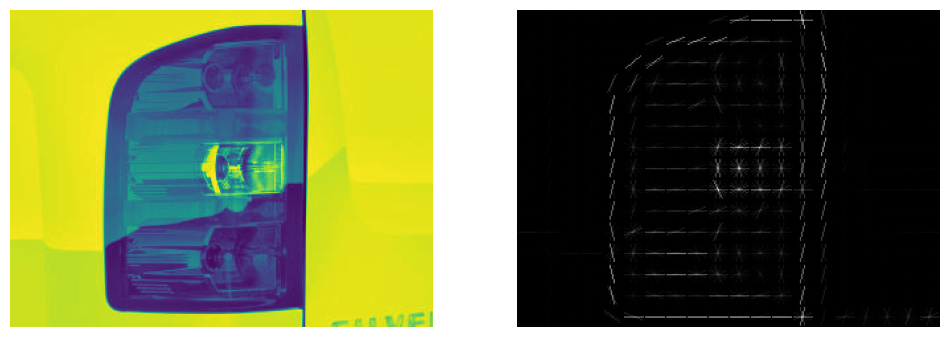

In [ ]:
example_image = np.asarray(PIL.Image.open(car_paths[0]))

# Convert the image to grayscale if it's multichannel
if example_image.ndim == 3:
    from skimage.color import rgb2gray
    example_image = rgb2gray(example_image)

hog_features,visualized = hog(example_image,orientations=9,pixels_per_cell=(16,16),
                              cells_per_block=(2,2),
                              visualize=True
                              #,
                              #multichannel=True
                             )

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(example_image)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

* And if we take a look at the hog_features, we can see its a vector. You should learn details of histogram of oriented gradients, I recommend analytics vidhya, they're explaining well.

In [ ]:
hog_features.shape

(9576,)

The code snippet below does the following task:
* Image Loading and Preprocessing: Loads car and non-car images, converts them to grayscale, and resizes them.
* HOG Feature Extraction: Extracts HOG features from each image using the hog function.
* Data Combination: Combines positive and negative images/labels into a single dataset (x, y).




In [ ]:
pos_images = []
neg_images = []

pos_labels = np.ones(len(car_paths))
neg_labels = np.zeros(len(neg_paths))

start = time.time()

for car_path in car_paths:
    img = np.asarray(PIL.Image.open(car_path))
    # We don't have to use RGB channels to extract features, Grayscale is enough.
    img = cv2.cvtColor(cv2.resize(img,(96,64)),cv2.COLOR_RGB2GRAY)
    img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )

    pos_images.append(img)

for neg_path in neg_paths:
    img = np.asarray(PIL.Image.open(neg_path))
    img = cv2.cvtColor(cv2.resize(img,(96,64)),cv2.COLOR_RGB2GRAY)
    img = hog(img,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2)
             )

    neg_images.append(img)

x = np.asarray(pos_images + neg_images)
y = np.asarray(list(pos_labels) + list(neg_labels))

processTime = round(time.time()-start,2)
print("Reading images and extracting features has taken {} seconds".format(processTime))

print("Shape of image set",x.shape)
print("Shape of labels",y.shape)

Reading images and extracting features has taken 29.01 seconds
Shape of image set (9900, 540)
Shape of labels (9900,)





**And now we came to the final step, splitting our dataset into train and test.**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7920, 540)
(1980, 540)
(7920,)
(1980,)


# Building Classifier
Our data is ready, now we'll build a Support Vector Machine classifier using sklearn.

In [ ]:
# Creating a SVC object
svc = SVC()

# Classifier will be trained using each parameter
svc.fit(x_train,y_train)

y_pred = svc.predict(x_test)
print("Accuracy score of model is ",accuracy_score(y_pred=y_pred,y_true=y_test)*100)


Accuracy score of model is  97.22222222222221


## Building sliding window and heatmap:

* First, we'll define a function that slides over an image and returns coords of the cells and feature extracted cells

(such as [coords=(w1=60,w2=154,h1=90,h2=154),features=(hog features with sahpe 540)]))

1. Feature Extraction via Sliding Windows
The function slideExtract:

Converts the input image to grayscale based on the specified color channel.
Iterates over the image using a sliding window approach, where the window size and stride (step) are configurable.
Extracts features using the Histogram of Oriented Gradients (HOG) descriptor for each window.
Stores the coordinates and the extracted features for further processing.


In [ ]:
def slideExtract(image,windowSize=(96,64),channel="RGB",step=12):

    # Converting to grayscale
    if channel == "RGB":
        img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    elif channel == "BGR":
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    elif channel.lower()!="grayscale" or channel.lower()!="gray":
        raise Exception("Invalid channel type")

    # We'll store coords and features in these lists
    coords = []
    features = []

    hIm,wIm = image.shape[:2]


    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):

        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = img[h1:h2,w1:w2]
            features_of_window = hog(window,orientations=9,pixels_per_cell=(16,16),
                                     cells_per_block=(2,2)
                                    )

            coords.append((w1,w2,h1,h2))
            features.append(features_of_window)

    return (coords,np.asarray(features))

* Let's try our sliding window function in an image.

In [ ]:
example_image = np.asarray(PIL.Image.open("/content/the-car-connection-picture-dataset/Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Mro.jpg"))
coords,features = slideExtract(example_image,channel="RGB")

coords[:5]

[(0, 96, 0, 64),
 (0, 96, 12, 76),
 (0, 96, 24, 88),
 (0, 96, 36, 100),
 (0, 96, 48, 112)]

In [ ]:
features.shape

(285, 540)

* As we can see there are 285 windows in a 320x240 image. That's why sliding window concept is slow.

Our sliding window is ready, now we'll define our heatmap. It will be a class.

2. Heatmap Handling
The Heatmap class:

Maintains a "heatmap" matrix that tracks the intensity of regions in the image based on detections.
Provides methods to increment or decrement the heatmap values for a given region.
Scales and thresholds the heatmap to identify regions of interest.
3. Object Detection
The detect function:

Uses the slideExtract function to process the image.
Initializes a heatmap using the Heatmap class.
Applies a pre-trained classifier (svc) to determine whether each window contains an object of interest.
Updates the heatmap accordingly and uses contours to identify bounding boxes around detected objects.
Draws bounding boxes on the original image to visualize detections.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():

    def __init__(self,original_image):

        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])

    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30

    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30

    def compileHeatmap(self):

        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8

        # Scaling between 0 and 1
        scaler = MinMaxScaler()

        self.mask = scaler.fit_transform(self.mask)


        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)

        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)

        return self.mask

Detect Fucntion

In [ ]:
def detect(image):

    # Make a copy of the image to avoid modifying the original
    image = image.copy()

    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)


    for i in range(len(features)):
        # If region is positive then add some heat
        decision = svc.predict([features[i]])
        if decision[0] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])

    # Compiling heatmap
    mask = htmp.compileHeatmap()

    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue

        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255, 0, 0),2) # Added (255, 0, 0) for RGB color

    return image

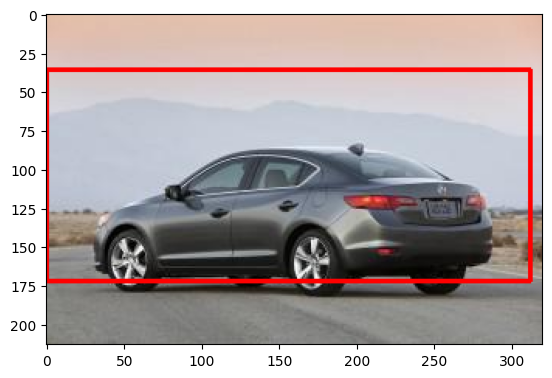

In [ ]:
detected = detect(np.asarray(PIL.Image.open("/content/the-car-connection-picture-dataset/Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_ylA.jpg")
                            ))
plt.imshow(detected)

# Outcome

This notebook demonstrated the construction of an object detector utilizing an SVM classifier and a sliding window approach. While the system performs reasonably well, its efficiency is hindered when processing high-resolution images, making it less practical compared to alternative methods like Haar cascades.

In the below snippets the results are explained.

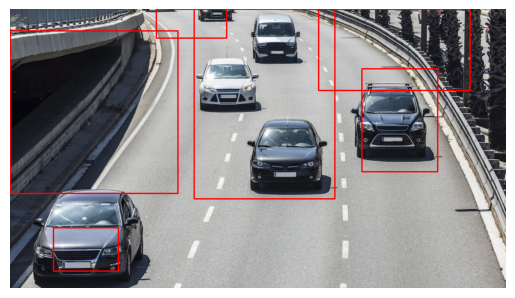

In [ ]:
import io
import requests

byte_img = requests.get("https://images2.minutemediacdn.com/image/upload/c_crop,h_843,w_1500,x_0,y_69/f_auto,q_auto,w_1100/v1554995310/shape/mentalfloss/istock-472964014.jpg").content
byte_img = io.BytesIO(byte_img)

img = np.asarray(PIL.Image.open(byte_img))

detected = detect(img)
plt.imshow(detected)
plt.axis("off")
plt.show()

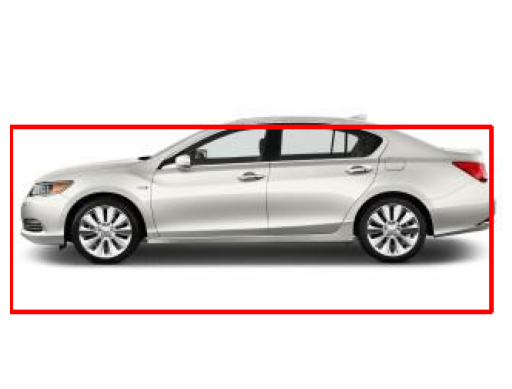

In [ ]:
from PIL import Image
image_path = "/content/the-car-connection-picture-dataset/Acura_RLX_2017_65_19_370_35_6_74_57_196_29_AWD_5_4_4dr_ewL.jpg"
img = np.asarray(Image.open(image_path))

# Perform object detection
detected = detect(img)

# Display the results
plt.imshow(detected)
plt.axis("off")
plt.show()

100%|██████████| 1.31M/1.31M [00:00<00:00, 79.9MB/s]

Extracting files...


'/content/test_images'

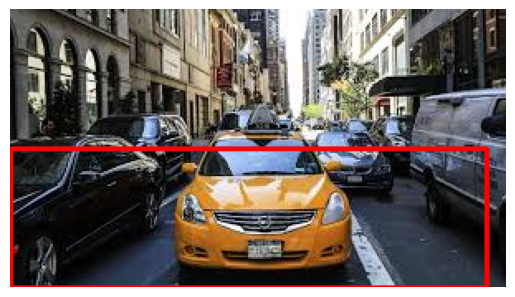

In [ ]:
from PIL import Image
image_path = "/content/test_images/pic3.jpg"
img = np.asarray(Image.open(image_path))

# Perform object detection
detected = detect(img)

# Display the results
plt.imshow(detected)
plt.axis("off")
plt.show()

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt -O /content/mscoco_label_map.pbtxt

--2024-12-08 17:10:42--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5056 (4.9K) [text/plain]
Saving to: ‘/content/mscoco_label_map.pbtxt’

/content/mscoco_lab 100%[===================>]   4.94K  --.-KB/s    in 0s      

2024-12-08 17:10:42 (43.1 MB/s) - ‘/content/mscoco_label_map.pbtxt’ saved [5056/5056]



In [ ]:
!pip install torch torchvision matplotlib
!pip install opencv-python-headless
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 16.1 MB/s eta 0:00:00


In [ ]:
#!pip install ultralytics

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the YOLOv8 pre-trained model
model = YOLO('yolov8s.pt')  # Ensure you have the proper YOLOv8 weights file

def detect_and_classify(image_path):
    # Load the image
    image = cv2.imread(image_path)
    original_image = image.copy()  # Keep a copy for visualization

    # Perform object detection using YOLOv8
    results = model(image)

    # Iterate over the detected objects
    for result in results:
        if result.boxes:  # Ensure boxes are available
            for box in result.boxes:
                # Extract bounding box coordinates, confidence score, and class ID
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())  # Bounding box coordinates
                conf = box.conf[0].item()  # Confidence score
                cls = int(box.cls[0].item())  # Class ID


                # Retrieve the class label
                label = result.names[cls]  # Class label (e.g., 'person', 'car')
                # Draw bounding box
                cv2.rectangle(
                    original_image,

                    (x1, y1),
                    (x2, y2),
                    (0, 255, 0), 2  # Green bounding box

                )

                # Create a label with object name and confidence score
                label_text = f"{label} {conf:.2f}"

                # Draw a filled rectangle for the label background
                (label_width, label_height), _ = cv2.getTextSize(
                    label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1
                )
                cv2.rectangle(
                    original_image,
                    (x1, y1 - label_height - 10),
                    (x1 + label_width + 5, y1),
                    (0, 255, 0), -1  # Filled rectangle
                )

                # Add label text on top of the rectangle
                cv2.putText(
                    original_image,
                    label_text,
                    (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,  # Smaller font size
                    (0, 0, 0), 1  # Black text
                )

    return original_image


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 130MB/s] 



0: 352x640 8 persons, 3 cars, 1 bus, 6 traffic lights, 1 fire hydrant, 960.8ms
Speed: 7.3ms preprocess, 960.8ms inference, 39.0ms postprocess per image at shape (1, 3, 352, 640)


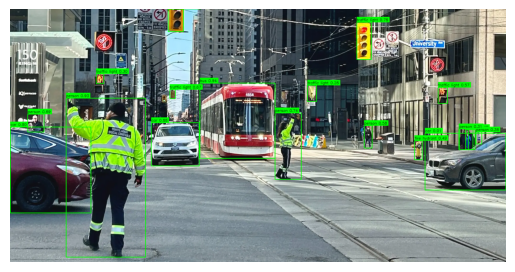

In [ ]:
# Path to the input image
image_path = "/content/test_images/pic5.webp"

# Detect and classify objects
output_image = detect_and_classify(image_path)

# Display the results
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


0: 448x640 7 cars, 1 potted plant, 1043.6ms
Speed: 6.8ms preprocess, 1043.6ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)


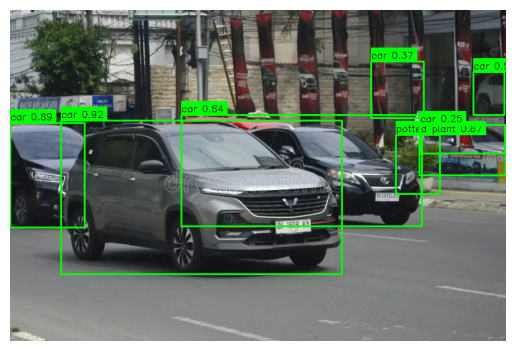

In [ ]:
# Path to the input image
image_path = "/content/test_images/pic2.webp"

# Detect and classify objects
output_image = detect_and_classify(image_path)

# Display the results
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


0: 384x640 6 cars, 1 truck, 1107.9ms
Speed: 11.8ms preprocess, 1107.9ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)


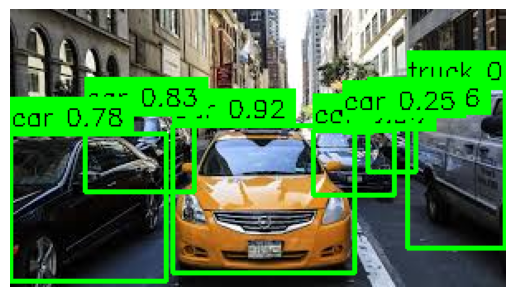

In [ ]:
# Path to the input image
image_path = "/content/test_images/pic3.jpg"

# Detect and classify objects
output_image = detect_and_classify(image_path)

# Display the results
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


0: 352x640 6 cars, 1 bus, 1 truck, 787.4ms
Speed: 2.9ms preprocess, 787.4ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)


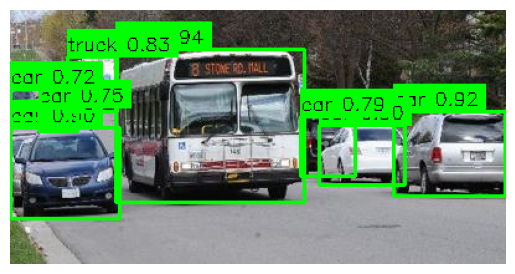

In [ ]:
# Path to the input image
image_path = "/content/test_images/pic4.jpg"

# Detect and classify objects
output_image = detect_and_classify(image_path)

# Display the results
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()